In [ ]:
#hide
from inpaint_covid import *

# Inpaint lung CT covid lesions

> Use inpainting to replace covid19 lesions with pseudo healthy textures.

Replace covid19 lesions in a CT using a unet.

## Install

`pip install octaviomtz/inpaint_covid`

or

In [ ]:
# !git clone https://github.com/octaviomtz/inpaint_covid.git
# !pip install nilearn
# from inpaint_covid.inpaint_covid import *

## How to use

### 0. Imports

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
import tensorflow as tf
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback
from tensorflow.keras import backend as K

### 1. Load and preprocess a CT scan and its masks:

In [ ]:
filename = 'covid19-A-0003_ct.nii.gz'
# if cloud
# from google.colab import drive
# drive.mount('/content/drive')
# path_source = '/content/drive/My Drive/Datasets/covid19/COVID-19-20_v2/'
# path_dest = '/content/drive/My Drive/KCL/covid19/inpainting_results/'
# if local
path_source = '/mnt/c/Users/octav/Documents/Datasets/COVID-19-20_v2/'
path_dest = '/mnt/c/Users/octav/Documents/Datasets/COVID-19-20_v2/inpainting_results/'
ct, ct_mask, ct_seg = read_covid_CT_and_mask(path_source, filename)
ct, ct_mask, ct_seg = normalize_rotate(ct, ct_mask, ct_seg)

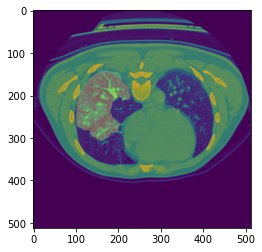

In [ ]:
plt.imshow(ct[...,100])
plt.imshow(ct_mask[...,100], alpha=.3);

### 2. Use the lung segmentation to use a smaller version of the CT

In [ ]:
# largest connected component
labelled, nr = label(ct_seg>0)
largest_component = (labelled == (np.bincount(labelled.flat)[1:].argmax() + 1))
ct_small, ct_mask_small, ct_seg_small = pad_volume_to_multiple_32(largest_component, ct, ct_mask, ct_seg)

/mnt/c/Users/octav/Documents/version_control/covid19/inpaint_covid/inpaint_covid/core.py:56: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, _, _ = measure.marching_cubes_lewiner(p, threshold, step_size=detail_speed)
/mnt/c/Users/octav/Documents/version_control/covid19/inpaint_covid/inpaint_covid/core.py:57: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts2, faces2, _, _ = measure.marching_cubes_lewiner(p2, threshold, step_size=detail_speed2)


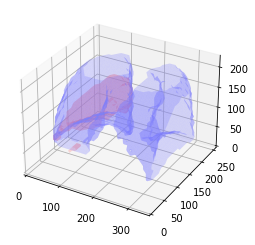

In [ ]:
labelled, nr = label(ct_seg_small>0)
largest_component = (labelled == (np.bincount(labelled.flat)[1:].argmax() + 1))
a=np.swapaxes(np.swapaxes(largest_component,1,2),0,1)
b=np.swapaxes(np.swapaxes(ct_mask_small,1,2),0,1)
plot_3d_2(a, b, .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

### 3. Get the masks

In [ ]:
bkgd = ct_seg_small == 0
target_mask = np.logical_or(bkgd,ct_mask_small)
target_mask = ~target_mask
target_mask2 = ~bkgd
target_mask3 = ct_mask_small.astype(bool)

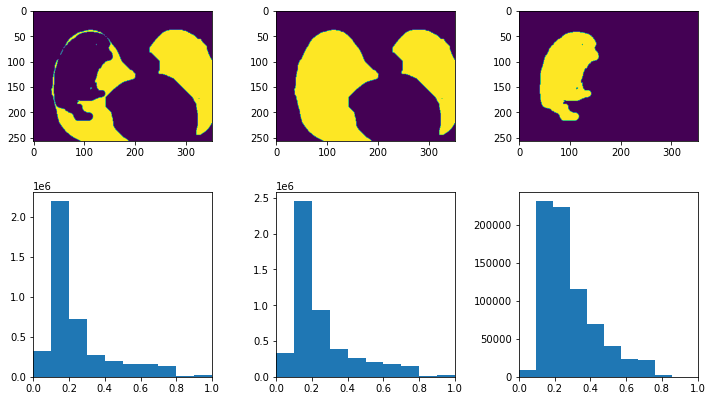

In [ ]:
SLICE=100
fig, ax = plt.subplots(2,3,figsize=(10,6))
ax[0,0].imshow(target_mask[...,SLICE])
ax[1,0].hist(ct_small[np.where(target_mask!=0)].flatten()); ax[1,0].set_xlim([0,1]);
ax[0,1].imshow(target_mask2[...,SLICE])
ax[1,1].hist(ct_small[np.where(target_mask2!=0)].flatten()); ax[1,1].set_xlim([0,1]);
ax[0,2].imshow(target_mask3[...,SLICE])
ax[1,2].hist(ct_small[np.where(target_mask3!=0)].flatten()); ax[1,2].set_xlim([0,1]);
plt.tight_layout()

### 4. Inpainting

In [ ]:
mask_target = np.expand_dims(target_mask,0) 
mask_target2 = np.expand_dims(target_mask2,0)
mask_target3 = np.expand_dims(target_mask3,0)

In [ ]:
# parameters
g_noise= 0.3
act_max_value = 1
act_out_max_value = 1
NOISE_REDUCTION = 0.75
EPOCHS = 2
EPOCHS_sneak_peek = 2
lr_value = 0.0001
LR_REDUCE = 1
archi = 5
ch_init = 32
version='v2.4'
SLICE=100
parameters = [g_noise, act_max_value, act_out_max_value, NOISE_REDUCTION, EPOCHS, EPOCHS_sneak_peek, lr_value, LR_REDUCE, archi, ch_init, version, filename, path_dest, SLICE]

In [ ]:
input_noise = np.random.rand(np.shape(ct_small)[0] ,np.shape(ct_small)[1], np.shape(ct_small)[2])
input_noise = np.expand_dims(input_noise,0) * NOISE_REDUCTION
target = np.expand_dims(ct_small,0)

In [ ]:
# USE THIS TO WORK WITH ONLY ONE SLICE
mask_target = np.expand_dims(mask_target[...,SLICE],-1)
mask_target2 = np.expand_dims(mask_target2[...,SLICE],-1)
mask_target3 = np.expand_dims(mask_target3[...,SLICE],-1)
input_noise = np.expand_dims(input_noise[...,SLICE],-1)
target = np.expand_dims(target[...,SLICE],-1)
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS  = np.shape(target[0])
SLICE = 0 # refer to the only slice available

In [ ]:
results_all = []
predicted_all = []
epochs_saved = [0]
previous_epochs = 0
model = get_architecture(target[0], archi, ch_init, g_noise, act_max_value, act_out_max_value)
opt = tf.keras.optimizers.Adam(lr_value) 
loss_masked, mask_used = choose_loss(mask_target, mask_target2, mask_target3, LOSS_USED=0)
model.compile(optimizer=opt, loss=loss_masked)

In [ ]:
# Train model
for i in tqdm(range(2)):
    results = model.fit(input_noise, target,  epochs=EPOCHS, verbose=0, callbacks=[TqdmCallback(verbose=0)]);
    results_all.extend(results.history['loss'])
    predicted_all.append(model.predict(input_noise)[0,...])
    epochs_saved.append(epochs_saved[-1] + EPOCHS)
    # sneak peek
    loss_masked, mask_used = choose_loss(mask_target, mask_target2, mask_target3, LOSS_USED=2)
    results = model.fit(input_noise, target,  epochs=EPOCHS_sneak_peek, verbose=0, callbacks=[TqdmCallback(verbose=0)]);
    loss_masked, mask_used = choose_loss(mask_target, mask_target2, mask_target3, LOSS_USED=0)
    results_all.extend(results.history['loss'])
    predicted_all.append(model.predict(input_noise)[0,...])
    epochs_sneak_peak = epochs_saved[-1] + EPOCHS_sneak_peek
    epochs_saved.append(epochs_sneak_peak)

    lr_value = lr_value * LR_REDUCE
    K.set_value(model.optimizer.learning_rate, lr_value)

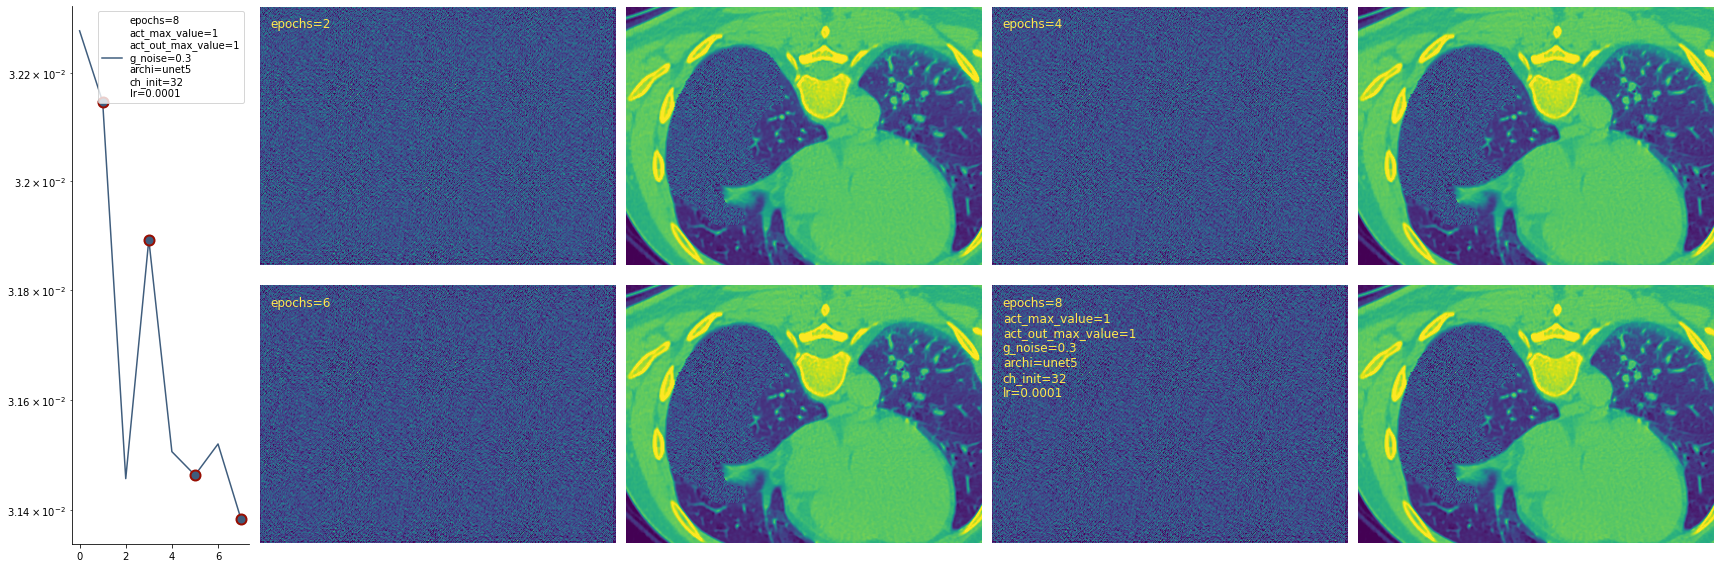

In [ ]:
# If using only one slice SLICE = 0
plot_inpaints_pairs(np.asarray(predicted_all)[...,SLICE], epochs_saved, target[0,...,SLICE], mask_used, mask_target3[0,...,SLICE], results_all, parameters, blend='blend', save=False)